# Attempt 3 is first GPU Attempt

https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/  
https://medium.com/analytics-vidhya/time-series-analysis-using-arima-and-lstm-in-python-and-keras-part2-74a79636568

# first need data  

In [1]:
import numpy
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

In [2]:
import os
os.listdir('../Data/Weekly/')

['AUDUSD10080 20201227.csv',
 'AUDUSD10080 20210103.csv',
 'AUDUSD10080_20200510.csv',
 'AUDUSD10080_20201220.csv',
 'Bitcoin Historical Data - Investing.com.csv',
 'BTC-USD_17Sep14to21Dec20.csv']

In [3]:
import pandas as pd

In [4]:
dat = pd.read_csv('../Data/Weekly/AUDUSD10080 20210103.csv', header=None)
dat.columns = ['Date','Time','Open','High','Low','Close','Volume']
dat

,Date,Time,Open,High,Low,Close,Volume
0,1993.04.25,00:00,0.72010,0.72650,0.70350,0.70750,6154
1,1993.05.02,00:00,0.70650,0.71050,0.69500,0.70950,4525
2,1993.05.09,00:00,0.70900,0.70950,0.69730,0.70350,6595
3,1993.05.16,00:00,0.70240,0.70400,0.68800,0.69530,5145
4,1993.05.23,00:00,0.69400,0.70150,0.68500,0.68750,5095
...,...,...,...,...,...,...,...
1430,2020.12.06,00:00,0.74291,0.75718,0.73725,0.75353,298404
1431,2020.12.13,00:00,0.75491,0.76394,0.75070,0.76214,245893
1432,2020.12.20,00:00,0.75846,0.76064,0.74618,0.75929,269942
1433,2020.12.27,00:00,0.76001,0.77420,0.75572,0.77065,183394


## get a look at time series

              Open         High          Low        Close         Volume  \
count  1435.000000  1435.000000  1435.000000  1435.000000    1435.000000   
mean      0.759626     0.768603     0.750394     0.759819  155403.756098   
std       0.134264     0.135411     0.132821     0.134182  182183.466445   
min       0.485800     0.497900     0.477500     0.484800      82.000000   
25%       0.677600     0.684850     0.668375     0.676850   15712.000000   
50%       0.745400     0.754400     0.738700     0.745900   42111.000000   
75%       0.817600     0.827310     0.804105     0.816780  274436.000000   
max       1.099390     1.107970     1.079530     1.099040  893411.000000   

              diff  
count  1435.000000  
mean      0.018209  
std       0.010479  
min       0.003500  
25%       0.011670  
50%       0.015770  
75%       0.021300  
max       0.138900  


<AxesSubplot:xlabel='Date'>

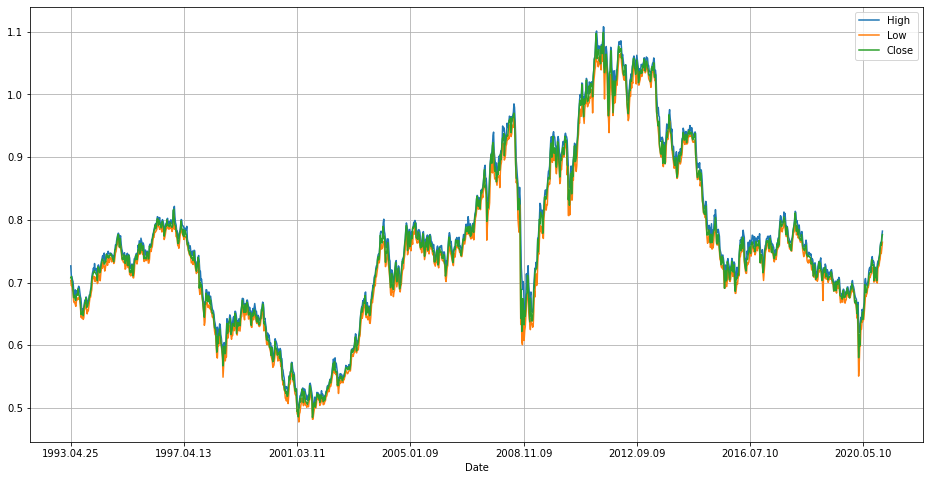

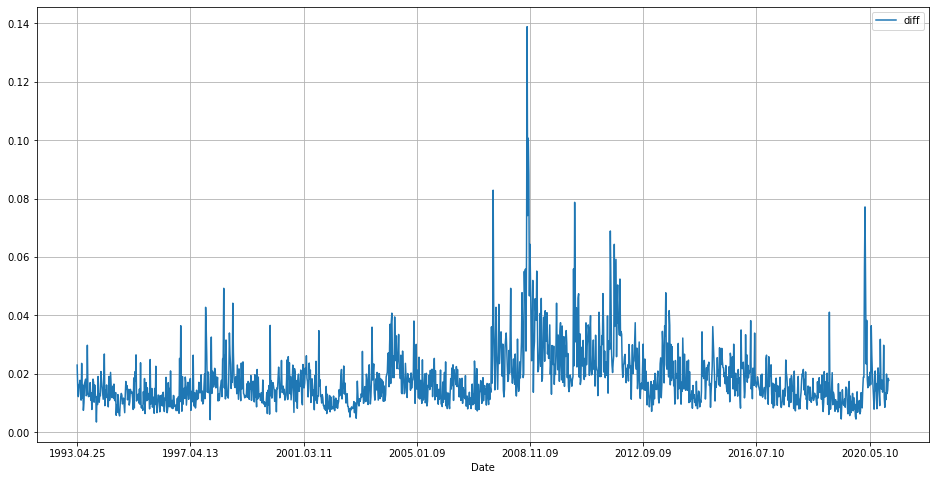

In [5]:
tmp = dat
tmp[['Date','High','Low','Close']].set_index('Date').plot(figsize=(16,8), grid=True)
tmp = tmp.assign(diff=lambda x: x.High - x.Low)
print(tmp.describe())
tmp[['Date','diff']].set_index('Date').plot(figsize=(16,8), grid=True)

In [6]:
dat.isnull().sum()

Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# then need to massage data  
    do we need to pad  
    setup test train data  
    create sequences

## scale then sequence the data

In [6]:
High = dat['High'].values

High = numpy.reshape(High, (-1,1))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
High_Scaled = scaler.fit_transform(High)

In [7]:
histlen = 60
X, Y = [], []
for i in range(histlen, len(High_Scaled)):
    X.append(High_Scaled[i-histlen:i, 0])
    Y.append(High_Scaled[i,0])
    
X, Y = numpy.array(X), numpy.array(Y)
print(X.shape)
print(dat.shape)

(1375, 60)
(1435, 7)


## Train test

In [8]:
test_pct = 0.333
train_cut = int(len(X)*(1-test_pct))

In [9]:
X_train, Y_train = X[:train_cut,:], Y[:train_cut]
X_test, Y_test = X[train_cut:], Y[train_cut:]

In [10]:
#need to reshape for LSTM as it wants a TENSOR ...(LEN, WID, Num_feat)
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# then need to setup lstm model  

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
import random


In [12]:
def fitMod(btch, epch, lyrs, unts_max, drpt_max, bestModName, lr = 1e-2, vrbs = 0):
   #strategy = tf.distribute.MirroredStrategy()
   # print('Number of devices: {}', format(strategy.num_replicas_in_sync))
    
    #with strategy.scope():
         
    model = Sequential()

    for i in range(0,lyrs):
        units = random.randrange(3,unts_max)
        dropout = random.uniform(0.03,drpt_max)
        details.append([btch, epch, lyrs, unts_max, drpt_max, bestModName, lr, i, units, dropout])
        if i == 0:
            model.add(LSTM(units = units, return_sequences = True, input_shape = (X_train.shape[1],1)))
        elif i == (lyrs-1):
            model.add(LSTM(units = units))
        else:
            model.add(LSTM(units = units, return_sequences = True))
        model.add(Dropout(dropout))       

    model.add(Dense(units = 1))
    opt = keras.optimizers.Adam(lr = lr)
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['mae','mape'])
    #model.summary()
    
    
    lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 **(epoch/20))
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'loss', mode = 'min', patience = 20)
    mc = keras.callbacks.ModelCheckpoint(bestModName, monitor = 'loss', mode = 'min', verbose = 0, save_best_only = True) #save best during training
    
    
    hist = model.fit(X_train, Y_train, epochs = epch, batch_size = btch, verbose = vrbs,
                     #             callbacks = [lr_schedule, mc, early_stopping],
                     callbacks = [mc, early_stopping],
                     validation_data = (X_test, Y_test)
                    )
    
    #print(model.evaluate(X_test))
    return(hist)
    #return(model)  



## generate grid for search of params
https://keras-team.github.io/keras-tuner/tutorials/distributed-tuning/#data-parallelism-with-tfdistribute  
https://machinelearningmastery.com/how-to-grid-search-deep-learning-models-for-time-series-forecasting/  
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/  
https://analyticsindiamag.com/how-to-use-keras-tuner-for-hyper-parameter-tuning-of-deep-learning-models/

### learning rate search
https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/

In [13]:
import itertools

def expand_grid(mydict):
    rows = itertools.product(*mydict.values())
    return pd.DataFrame.from_records(rows, columns = mydict.keys())

batch = [8, 16, 32]
epoch = [3,9,27]
layers = [2,4,8]
units_max = [33]
dropout_max = [0.66]
learning_rate = [1e-1, 1e-2, 1e-3]

param_grid = dict(btch = batch, epch = epoch, lyrs = layers, unts_max = units_max, drpt_max = dropout_max, lr = learning_rate)
param_grid_expanded = expand_grid(param_grid)
param_grid_expanded['filename'] = ['./mod_grid_results/attempt_3_II_' + str(i) + '.h5' for i,r in param_grid_expanded.iterrows()]
param_grid_expanded

,btch,epch,lyrs,unts_max,drpt_max,lr,filename
0,8,3,2,33,0.66,0.100,./mod_grid_results/attempt_3_II_0.h5
1,8,3,2,33,0.66,0.010,./mod_grid_results/attempt_3_II_1.h5
2,8,3,2,33,0.66,0.001,./mod_grid_results/attempt_3_II_2.h5
3,8,3,4,33,0.66,0.100,./mod_grid_results/attempt_3_II_3.h5
4,8,3,4,33,0.66,0.010,./mod_grid_results/attempt_3_II_4.h5
...,...,...,...,...,...,...,...
76,32,27,4,33,0.66,0.010,./mod_grid_results/attempt_3_II_76.h5
77,32,27,4,33,0.66,0.001,./mod_grid_results/attempt_3_II_77.h5
78,32,27,8,33,0.66,0.100,./mod_grid_results/attempt_3_II_78.h5
79,32,27,8,33,0.66,0.010,./mod_grid_results/attempt_3_II_79.h5


## Model creation and FIT ...now with RYO grid search

In [14]:
details = []
attempt_3 = fitMod(8, 3, 3, 33, 0.33, "./mod_grid_results/attempt_3_II_M1.h5", 0.05)
details

[[8,
  3,
  3,
  33,
  0.33,
  './mod_grid_results/attempt_3_II_M1.h5',
  0.05,
  0,
  31,
  0.2694851720641753],
 [8,
  3,
  3,
  33,
  0.33,
  './mod_grid_results/attempt_3_II_M1.h5',
  0.05,
  1,
  23,
  0.05100773709478964],
 [8,
  3,
  3,
  33,
  0.33,
  './mod_grid_results/attempt_3_II_M1.h5',
  0.05,
  2,
  18,
  0.16198160035980455]]

In [15]:
#for index, data in param_grid_expanded.iterrows():
details = []
for i, b,e,l,u,d,r,f in param_grid_expanded.itertuples():
    hist = fitMod(b, e, l, u, d, f, r)

# Load best mod to review predictions  

In [16]:
from keras.models import load_model
from sklearn.metrics import explained_variance_score, max_error 
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_tweedie_deviance, mean_squared_error

def reviewPreds(bestModName):
    
    best = load_model(bestModName)    
    preds = best.predict(X_test)
    mse = mean_squared_error(preds,Y_test)
    Test_Scores = {"Mean Square Error": round(mse,5),
               "Explained Variance Score": round(explained_variance_score(Y_test, preds),5),
               "Max Error": round(max_error(Y_test, preds),5),
               "Mean Absolute Error": round(mean_absolute_error(Y_test, preds), 5),
               "Median Absolute Error": round(median_absolute_error(Y_test, preds), 5),
               "Mean Tweedie Deviance (P=1)": round(mean_tweedie_deviance(Y_test, preds, power = 1),3),
               "Mean Tweedie Deviance (P=2)": round(mean_tweedie_deviance(Y_test, preds, power = 2), 3)}
    return(best, preds, mse, Test_Scores)

In [17]:
#load_model('attempt_3_ii_20.h5').summary()
#reviewPreds('attempt_3_13.h5')[2]
#param_grid_expanded_sml = param_grid_expanded[4: ]
#mean_squared_error(load_model('attempt_3_ii_7.h5').predict(X_test), Y_test)
param_grid_expanded_sml = param_grid_expanded.query('lyrs > 1')
param_grid_expanded_sml

,btch,epch,lyrs,unts_max,drpt_max,lr,filename
0,8,3,2,33,0.66,0.100,./mod_grid_results/attempt_3_II_0.h5
1,8,3,2,33,0.66,0.010,./mod_grid_results/attempt_3_II_1.h5
2,8,3,2,33,0.66,0.001,./mod_grid_results/attempt_3_II_2.h5
3,8,3,4,33,0.66,0.100,./mod_grid_results/attempt_3_II_3.h5
4,8,3,4,33,0.66,0.010,./mod_grid_results/attempt_3_II_4.h5
...,...,...,...,...,...,...,...
76,32,27,4,33,0.66,0.010,./mod_grid_results/attempt_3_II_76.h5
77,32,27,4,33,0.66,0.001,./mod_grid_results/attempt_3_II_77.h5
78,32,27,8,33,0.66,0.100,./mod_grid_results/attempt_3_II_78.h5
79,32,27,8,33,0.66,0.010,./mod_grid_results/attempt_3_II_79.h5


In [18]:

param_grid_expanded_sml['mse'] = [round(reviewPreds(f)[2],7) for f in param_grid_expanded_sml['filename']]

In [19]:
print(param_grid_expanded_sml.sort_values(by = 'mse'))

    btch  epch  lyrs  unts_max  drpt_max     lr  \
19     8    27     2        33      0.66  0.010   
49    16    27     4        33      0.66  0.010   
73    32    27     2        33      0.66  0.010   
72    32    27     2        33      0.66  0.100   
20     8    27     2        33      0.66  0.001   
..   ...   ...   ...       ...       ...    ...   
69    32     9     8        33      0.66  0.100   
30    16     3     4        33      0.66  0.100   
0      8     3     2        33      0.66  0.100   
57    32     3     4        33      0.66  0.100   
3      8     3     4        33      0.66  0.100   

                                 filename       mse  
19  ./mod_grid_results/attempt_3_II_19.h5  0.000447  
49  ./mod_grid_results/attempt_3_II_49.h5  0.000528  
73  ./mod_grid_results/attempt_3_II_73.h5  0.000652  
72  ./mod_grid_results/attempt_3_II_72.h5  0.000781  
20  ./mod_grid_results/attempt_3_II_20.h5  0.000798  
..                                    ...       ...  
69  ./mod

In [20]:
for r in details:
    if r[5] == './mod_grid_results/attempt_3_II_19.h5':
        print(r)
# best, preds, mse, Test_Scores = reviewPreds('best_mod_test_grid.h5')
# for item in Test_Scores:
#     print(f'{item:<30} {Test_Scores[item]:<8}')


[8, 27, 2, 33, 0.66, './mod_grid_results/attempt_3_II_19.h5', 0.01, 0, 13, 0.30447264846258937]
[8, 27, 2, 33, 0.66, './mod_grid_results/attempt_3_II_19.h5', 0.01, 1, 30, 0.5045990877252619]


## Plot preds against actuals

In [21]:
import matplotlib.pyplot as plt

def runplots(tmp):
    
    gridsize = int(numpy.ceil(numpy.sqrt(len(tmp))))
    i = 0
    j = 0
    fig, axs = plt.subplots(gridsize,gridsize, figsize = (20,16))
    for f in tmp['filename']:
        best, preds, mse, Test_Scores = reviewPreds(f)
        #runplots(preds, mse).show()

        axs[i % 2, int((1+i)/2 % 2)].plot(Y_test, color = 'blue', label = 'Actual High')
        axs[i % 2, int((1+i)/2 % 2)].plot(preds, color = 'red', label = 'Predicted High')
        axs[i % 2, int((1+i)/2 % 2)].set_title('Compare Actual Vs Predicted High\n MSE = ' + str(round(mse,7)))
        
        i += 1
        j += 1

    plt.xlabel('Date')
    plt.ylabel('Scaled High')
    plt.legend()
    fig.tight_layout()
    plt.show()    


    btch  epch  lyrs  unts_max  drpt_max     lr  \
19     8    27     2        33      0.66  0.010   
49    16    27     4        33      0.66  0.010   
73    32    27     2        33      0.66  0.010   
72    32    27     2        33      0.66  0.100   
20     8    27     2        33      0.66  0.001   

                                 filename       mse  
19  ./mod_grid_results/attempt_3_II_19.h5  0.000447  
49  ./mod_grid_results/attempt_3_II_49.h5  0.000528  
73  ./mod_grid_results/attempt_3_II_73.h5  0.000652  
72  ./mod_grid_results/attempt_3_II_72.h5  0.000781  
20  ./mod_grid_results/attempt_3_II_20.h5  0.000798  


No handles with labels found to put in legend.


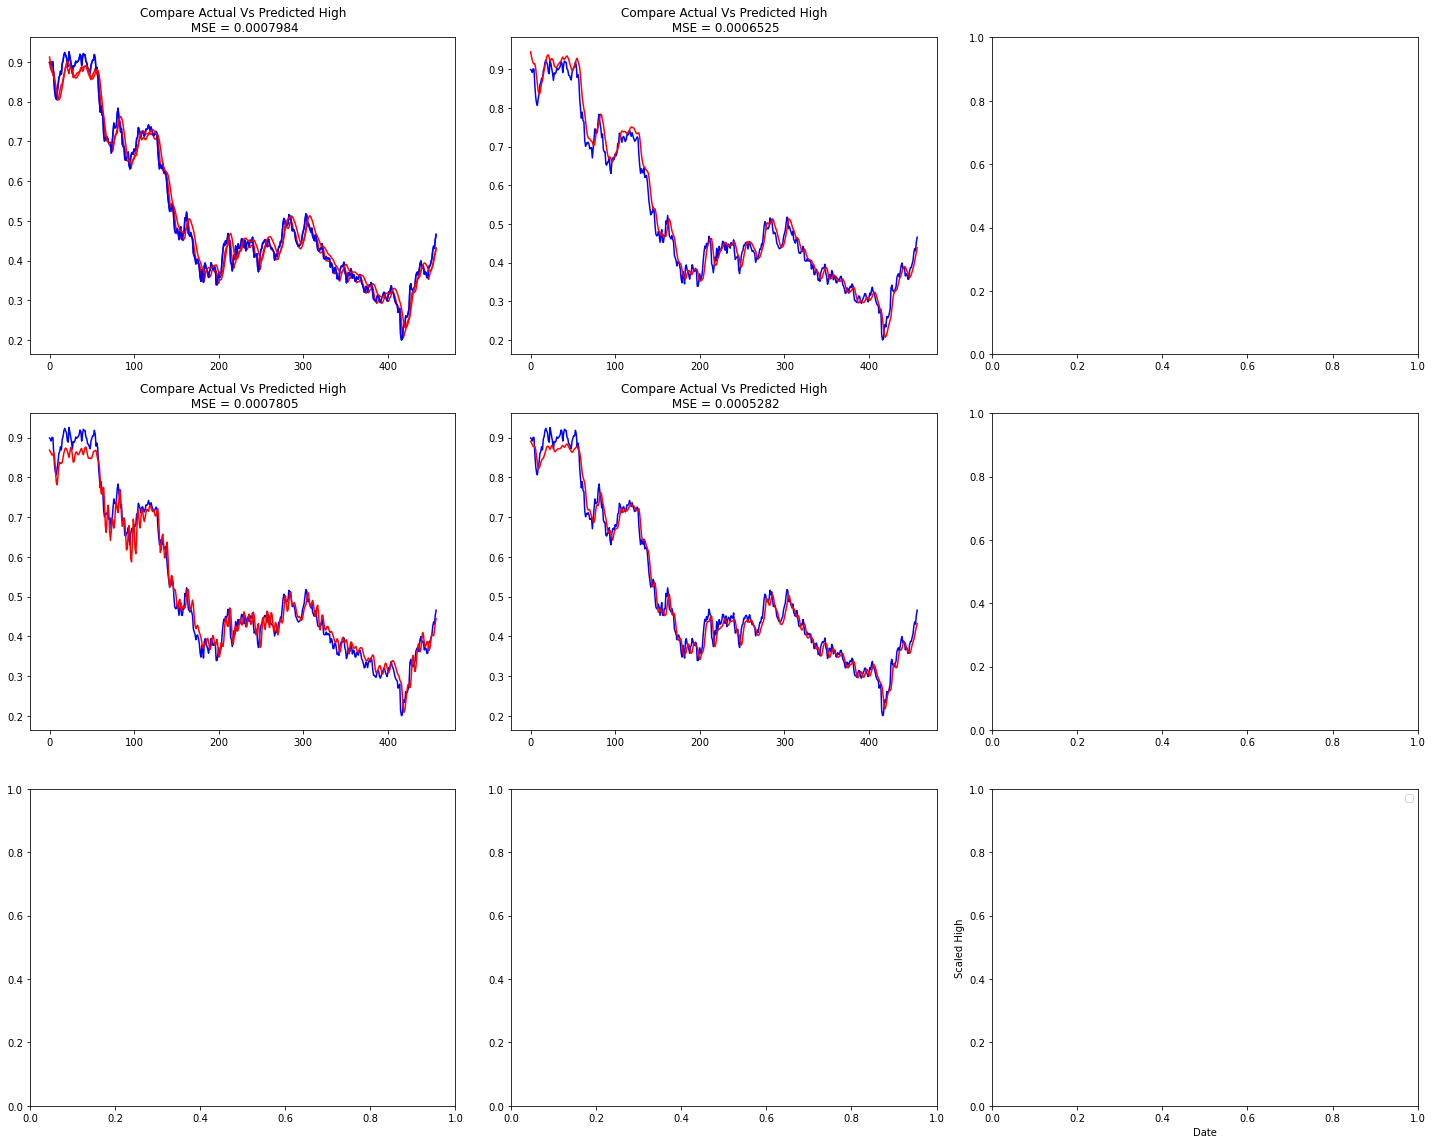

In [22]:
tmp = param_grid_expanded_sml.sort_values(by = ['mse']).head()
print(tmp)
runplots(tmp)
#current best settings
#batch  = 4, epochs = 27, layers = 2, units max = 33, dropout max = .66, learning rate = 0.01

In [24]:
#get singleton plot data
#best, preds, mse, Test_Scores = reviewPreds('best_mod_62.h5')
#best, preds, mse, Test_Scores = reviewPreds('best_mod_113.h5')
best, preds, mse, Test_Scores = reviewPreds('./mod_grid_results/attempt_3_II_19.h5')

In [25]:
#best = load_model('best_mod_62.h5')
#best = load_model('attempt_3_13.h5')
print(best.summary())


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 60, 13)            780       
_________________________________________________________________
dropout_89 (Dropout)         (None, 60, 13)            0         
_________________________________________________________________
lstm_90 (LSTM)               (None, 30)                5280      
_________________________________________________________________
dropout_90 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 31        
Total params: 6,091
Trainable params: 6,091
Non-trainable params: 0
_________________________________________________________________
None


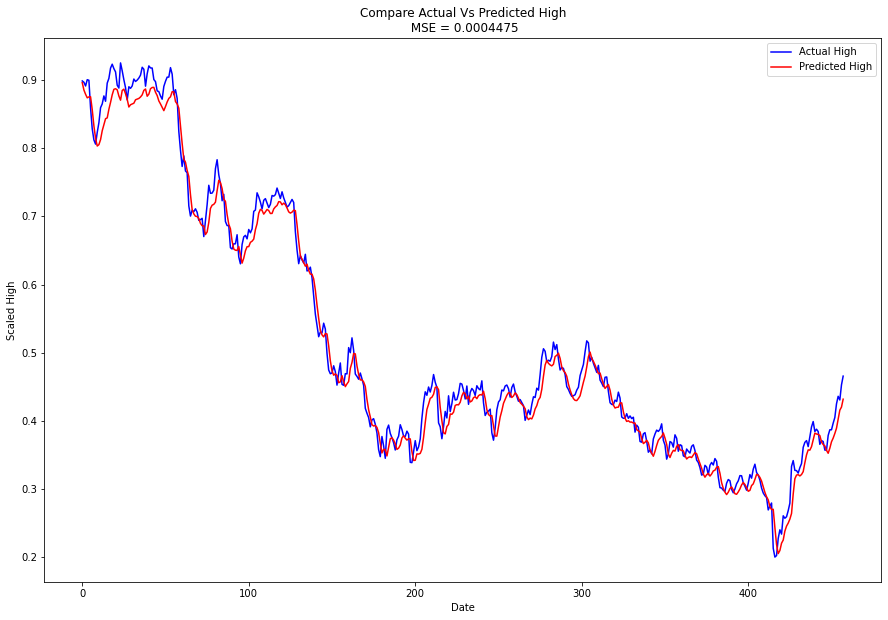

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(Y_test, color = 'blue', label = 'Actual High')
plt.plot(preds, color = 'red', label = 'Predicted High')
plt.title('Compare Actual Vs Predicted High\n MSE = ' + str(round(mse,7)))
plt.xlabel('Date')
plt.ylabel('Scaled High')
plt.legend()
plt.show()    


In [27]:
param_grid_expanded_sml.sort_values(by = ['mse'])

,btch,epch,lyrs,unts_max,drpt_max,lr,filename,mse
19,8,27,2,33,0.66,0.010,./mod_grid_results/attempt_3_II_19.h5,0.000447
49,16,27,4,33,0.66,0.010,./mod_grid_results/attempt_3_II_49.h5,0.000528
73,32,27,2,33,0.66,0.010,./mod_grid_results/attempt_3_II_73.h5,0.000652
72,32,27,2,33,0.66,0.100,./mod_grid_results/attempt_3_II_72.h5,0.000781
20,8,27,2,33,0.66,0.001,./mod_grid_results/attempt_3_II_20.h5,0.000798
...,...,...,...,...,...,...,...,...
69,32,9,8,33,0.66,0.100,./mod_grid_results/attempt_3_II_69.h5,0.056828
30,16,3,4,33,0.66,0.100,./mod_grid_results/attempt_3_II_30.h5,0.057276
0,8,3,2,33,0.66,0.100,./mod_grid_results/attempt_3_II_0.h5,0.057504
57,32,3,4,33,0.66,0.100,./mod_grid_results/attempt_3_II_57.h5,0.060883


# Can we predict LOW using the same modell...

In [28]:
Low = dat['Low'].values

Low = numpy.reshape(Low, (-1,1))
scaler_low = MinMaxScaler(feature_range = (0,1))
Low_Scaled = scaler_low.fit_transform(Low)
histlen = 60
X_low, Y_low = [], []
for i in range(histlen, len(Low_Scaled)):
    X_low.append(Low_Scaled[i-histlen:i, 0])
    Y_low.append(Low_Scaled[i,0])
    
X_low, Y_low = numpy.array(X_low), numpy.array(Y_low)
print(X_low.shape)
print(dat.shape)

X_low_train, Y_low_train = X_low[:train_cut,:], Y_low[:train_cut]
X_low_test, Y_low_test = X_low[train_cut:], Y_low[train_cut:]
#need to reshape for LSTM as it wants a TENSOR ...(LEN, WID, Num_feat)
X_low_train = numpy.reshape(X_low_train, (X_low_train.shape[0], X_low_train.shape[1], 1))
X_low_test = numpy.reshape(X_low_test, (X_low_test.shape[0], X_low_test.shape[1], 1))

(1375, 60)
(1435, 7)


In [29]:
preds_low = best.predict(X_low_test)
mse_low = mean_squared_error(preds_low,Y_low_test)
mse_low

0.0005312360820287713

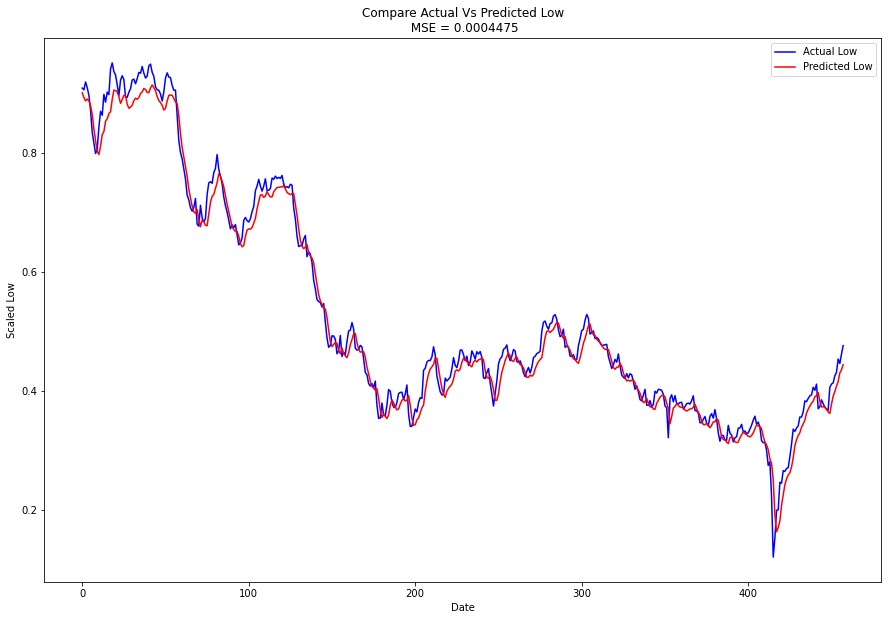

In [30]:
plt.figure(figsize=(15,10))
plt.plot(Y_low_test, color = 'blue', label = 'Actual Low')
plt.plot(preds_low, color = 'red', label = 'Predicted Low')
plt.title('Compare Actual Vs Predicted Low\n MSE = ' + str(round(mse,7)))
plt.xlabel('Date')
plt.ylabel('Scaled Low')
plt.legend()
plt.show()    

# Can we predict CLOSE using the same modell...

In [31]:
Close = dat['Close'].values

Close = numpy.reshape(Close, (-1,1))
scaler_close = MinMaxScaler(feature_range = (0,1))
Close_Scaled = scaler_close.fit_transform(Close)
histlen = 60
X_close, Y_close = [], []
for i in range(histlen, len(Close_Scaled)):
    X_close.append(Close_Scaled[i-histlen:i, 0])
    Y_close.append(Close_Scaled[i,0])
    
X_close, Y_close = numpy.array(X_close), numpy.array(Y_close)
print(X_close.shape)
print(dat.shape)

X_close_train, Y_close_train = X_close[:train_cut,:], Y_close[:train_cut]
X_close_test, Y_close_test = X_close[train_cut:], Y_close[train_cut:]
#need to reshape for LSTM as it wants a TENSOR ...(LEN, WID, Num_feat)
X_close_train = numpy.reshape(X_close_train, (X_close_train.shape[0], X_close_train.shape[1], 1))
X_close_test = numpy.reshape(X_close_test, (X_close_test.shape[0], X_close_test.shape[1], 1))

(1375, 60)
(1435, 7)


In [32]:
preds_close = best.predict(X_close_test)
mse_close = mean_squared_error(preds_close,Y_close_test)
mse_close

0.0005346142435367256

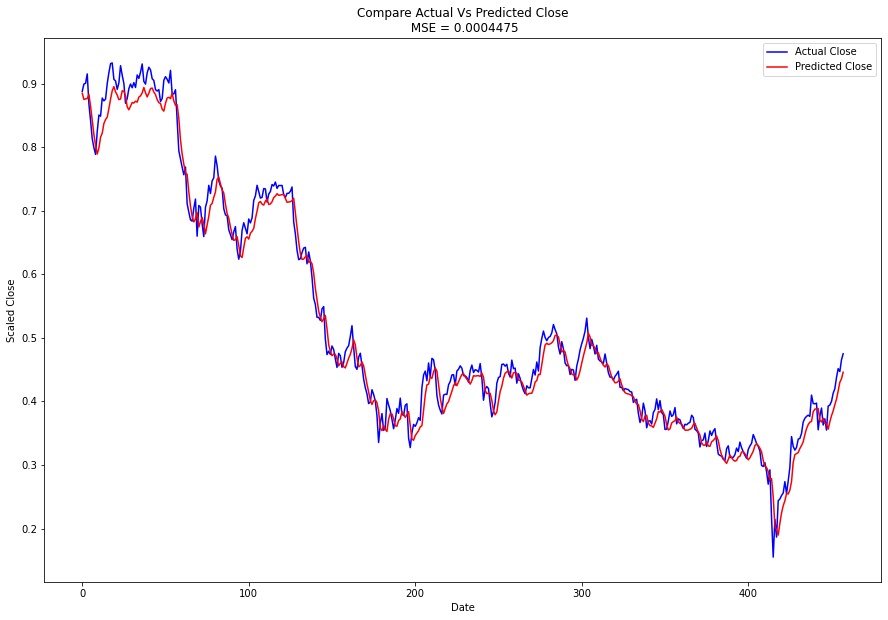

In [33]:
plt.figure(figsize=(15,10))
plt.plot(Y_close_test, color = 'blue', label = 'Actual Close')
plt.plot(preds_close, color = 'red', label = 'Predicted Close')
plt.title('Compare Actual Vs Predicted Close\n MSE = ' + str(round(mse,7)))
plt.xlabel('Date')
plt.ylabel('Scaled Close')
plt.legend()
plt.show()    

# now compare all predicted values...

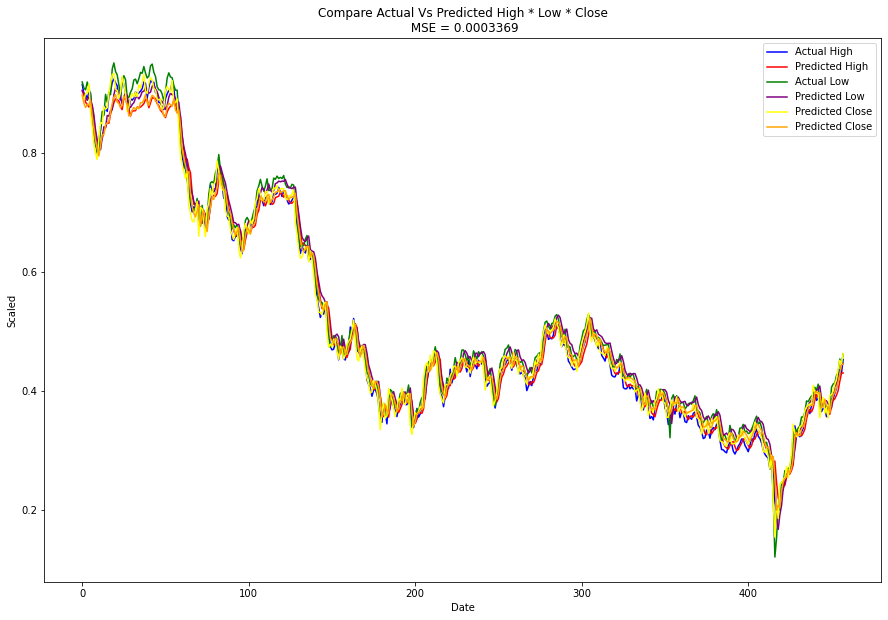

In [51]:
plt.figure(figsize=(15,10))
plt.plot(Y_test, color = 'blue', label = 'Actual High')
plt.plot(preds, color = 'red', label = 'Predicted High')
plt.plot(Y_low_test, color = 'green', label = 'Actual Low')
plt.plot(preds_low, color = 'purple', label = 'Predicted Low')
plt.plot(Y_close_test, color  = 'yellow', label = 'Predicted Close')
plt.plot(preds_close, color = 'orange', label = 'Predicted Close')
plt.title('Compare Actual Vs Predicted High * Low * Close\n MSE = ' + str(round(mse,7)))
plt.xlabel('Date')
plt.ylabel('Scaled')
plt.legend()
plt.show()    

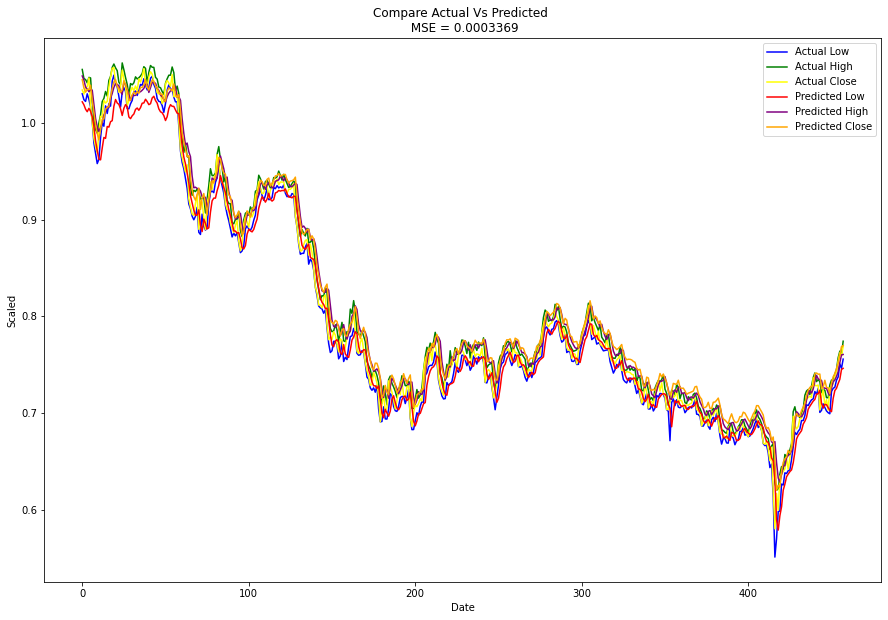

In [52]:


plt.figure(figsize=(15,10))
plt.plot(Low[train_cut+60:], color = 'blue', label = 'Actual Low')
plt.plot(High[train_cut+60:], color = 'green', label = 'Actual High')
plt.plot(Close[train_cut + 60: ], color = 'yellow', label = 'Actual Close')
plt.plot(scaler_low.inverse_transform(preds_low), color = 'red', label = 'Predicted Low')
plt.plot(scaler.inverse_transform(preds), color = 'purple', label = 'Predicted High')
plt.plot(scaler.inverse_transform(preds_close), color = 'orange', label = 'Predicted Close')
#plt.plot(Y_low_test, color = 'green', label = 'Actual Low')
#plt.plot(preds_low, color = 'purple', label = 'Predicted Low')
plt.title('Compare Actual Vs Predicted \n MSE = ' + str(round(mse,7)))
plt.xlabel('Date')
plt.ylabel('Scaled')
plt.legend()
plt.show()    

In [34]:
A = list(itertools.chain(*preds))
B = Y_test

print(pd.DataFrame(B - A).describe())


A = list(itertools.chain(*preds_low))
B = Y_low_test

print(pd.DataFrame(B - A).describe())


A = list(itertools.chain(*preds_close))
B = Y_close_test

print(pd.DataFrame(B - A).describe())
#d = {'Y_low_test':pd.Series(Y_low_test.data),
#   'preds_low':pd.Series(preds_low.data)
#}
#pd.DataFrame(d)
#pd.DataFrame({'diff' = pd.Series(Y_low_test.data) - pd.Series(list(preds_low))})
#Y_low_test
#preds_low

                0
count  458.000000
mean     0.008837
std      0.019240
min     -0.057214
25%     -0.002526
50%      0.009497
75%      0.020929
max      0.069179
                0
count  458.000000
mean     0.009191
std      0.021160
min     -0.129754
25%     -0.002717
50%      0.009902
75%      0.022201
max      0.071602
                0
count  458.000000
mean     0.008946
std      0.021344
min     -0.094606
25%     -0.004083
50%      0.010062
75%      0.022483
max      0.070617


#### ANSWER: YES but we could possibly do better with specific model???


# now we need to do one ahead prediction...NOTE Xmas prolly not the best week to be testing this out...

In [35]:

Y_test[-3:] #X_test[-1:]

array([0.43067189, 0.45289885, 0.46568427])

In [44]:
# predict HIGH
exp_high = scaler.inverse_transform(best.predict(numpy.append(X_test[-1:].reshape(60)[1:],Y_test[-1]).reshape(1,60,1)))
print(pd.DataFrame([(exp_high - 0.012, exp_high, exp_high + 0.012)]))

               0              1               2
0  [[0.7573104]]  [[0.7693104]]  [[0.78131044]]


In [37]:
#predict LOW
exp_low = scaler_low.inverse_transform(best.predict(numpy.append(X_low_test[-1:].reshape(60)[1:],Y_low_test[-1]).reshape(1,60,1)))
print(pd.DataFrame([(exp_low - 0.012, exp_low, exp_low + 0.012)]))

                0              1              2
0  [[0.74013305]]  [[0.7521331]]  [[0.7641331]]


In [74]:
#predict CLOSE
exp_close = scaler_close.inverse_transform(best.predict(numpy.append(X_close_test[-1:].reshape(60)[1:],Y_close_test[-1]).reshape(1,60,1)))
print(pd.DataFrame([(exp_close - 0.012, exp_close, exp_close + 0.012)]))

               0              1              2
0  [[0.7528719]]  [[0.7648719]]  [[0.7768719]]


In [52]:

accountRatio = 1/100
balance = 10000
size = 1
price = 0.775
takeProfit = 0.7655
stopLoss = 0.782

def tradeResults(price, takeProfit, stopLoss, accountRatio = 1/100, balance = 10000, size = 2):
    investment = (size*10*balance*accountRatio)
    pips = (investment / price)
    reward = 100 * pips * (takeProfit - price)
    risk = 100 * pips * (stopLoss - price)
    rewardrisk = reward/(-1*risk)
    print(f'investment {round(investment,2):>7} ($)')
    print(f'pips {pips:>25}')
    print(f'eReward {round(reward,2):>11} ($)')
    print(f'@ Risk {round(risk,2):>12} ($)')
    print(f'Reward/Risk {round(rewardrisk,2):>7}')
    print(f'Profit % {round(reward/investment,2):>10} (%)')
    print(f'Risk % {round(risk/investment,2):>12} (%)')
    print('\n')
    if rewardrisk > 1.5:
        print('Decision : Do the deal************')
    elif rewardrisk > 1.24:
        print('Decision : Some trepidation---------')
    else:
        print('Decision : RUNAWAY!!!!!!!!!!!!')
    print('\n')
    
tradeResults(price, takeProfit, stopLoss, size = size)

investment  1000.0 ($)
pips        1290.3225806451612
eReward    -1225.81 ($)
@ Risk       903.23 ($)
Reward/Risk    1.36
Profit %      -1.23 (%)
Risk %          0.9 (%)


Decision : Some trepidation---------




In [ ]:
#$10000 equity, 100:1 account, 2 = $2000

# can we do better by building a model with the LOW and HIGH fed in as inputs???
# can we do better by using Volume as an input???

# YET TO DO:  then need to determine if can improve model  
model diagnosis

# YET TO DO: make parallel version for fit...+ preds